# EDA

In [3]:


import json
import pandas as pd
import numpy as np

import os
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")


## Importing and Inspecting the Data

In [4]:
data_train = pd.read_csv('../data/train.csv')
data_test = pd.read_csv('../data/test.csv')

In [5]:
data_train.shape, data_test.shape

((1687861, 23), (242076, 23))

In [6]:
data_test.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

```
sku - sku code
national_inv - Current inventory level of component
lead_time - Transit time
in_transit_qtry - Quantity in transit
forecast_x_month - Forecast sales for the net 3, 6, 9 months
sales_x_month - Sales quantity for the prior 1, 3, 6, 9 months
min_bank - Minimum recommended amount in stock
potential_issue - Indictor variable noting potential issue with item
pieces_past_due - Parts overdue from source
perf_x_months_avg - Source performance in the last 6 and 12 months
local_bo_qty - Amount of stock orders overdue
X17-X22 - General Risk Flags
went_on_back_order - Product went on backorder
Validation - indicator variable for training (0), validation (1), and test set (2)
```

In [7]:
data_test.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3285085,62.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
1,3285131,9.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-99.00,-99.00,0.0,No,No,Yes,No,No,No
2,3285358,17.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.92,0.95,0.0,No,No,No,Yes,No,No
3,3285517,9.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.78,0.75,0.0,No,No,Yes,Yes,No,No
4,3285608,2.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.54,0.71,0.0,No,No,No,Yes,No,No


## Handling Missing Data

In [8]:
null_counts = data_test.isnull().sum()
columns_with_nulls = null_counts[null_counts > 0]
print(null_counts)

sku                      0
national_inv             1
lead_time            14725
in_transit_qty           1
forecast_3_month         1
forecast_6_month         1
forecast_9_month         1
sales_1_month            1
sales_3_month            1
sales_6_month            1
sales_9_month            1
min_bank                 1
potential_issue          1
pieces_past_due          1
perf_6_month_avg         1
perf_12_month_avg        1
local_bo_qty             1
deck_risk                1
oe_constraint            1
ppap_risk                1
stop_auto_buy            1
rev_stop                 1
went_on_backorder        1
dtype: int64


There is one row that is incomplete/broken, pick one column to drop the row.
Most of values are null in lead_time, replace with median.

In [9]:
# Check nulls in test data again
data_test.dropna(subset=['went_on_backorder'], inplace=True)
median_lead_time = data_test['lead_time'].median()
# Fill null values with the median
data_test['lead_time'].fillna(median_lead_time, inplace=True)
print("\n--- Test Data Null Counts After Cleanup ---")
print(data_test.isnull().sum())


--- Test Data Null Counts After Cleanup ---
sku                  0
national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64


In [10]:
# same for training data
data_train.dropna(subset=['went_on_backorder'], inplace=True)
median_lead_time = data_train['lead_time'].median()

data_train['lead_time'].fillna(median_lead_time, inplace=True)

## Exploring Data Characteristics

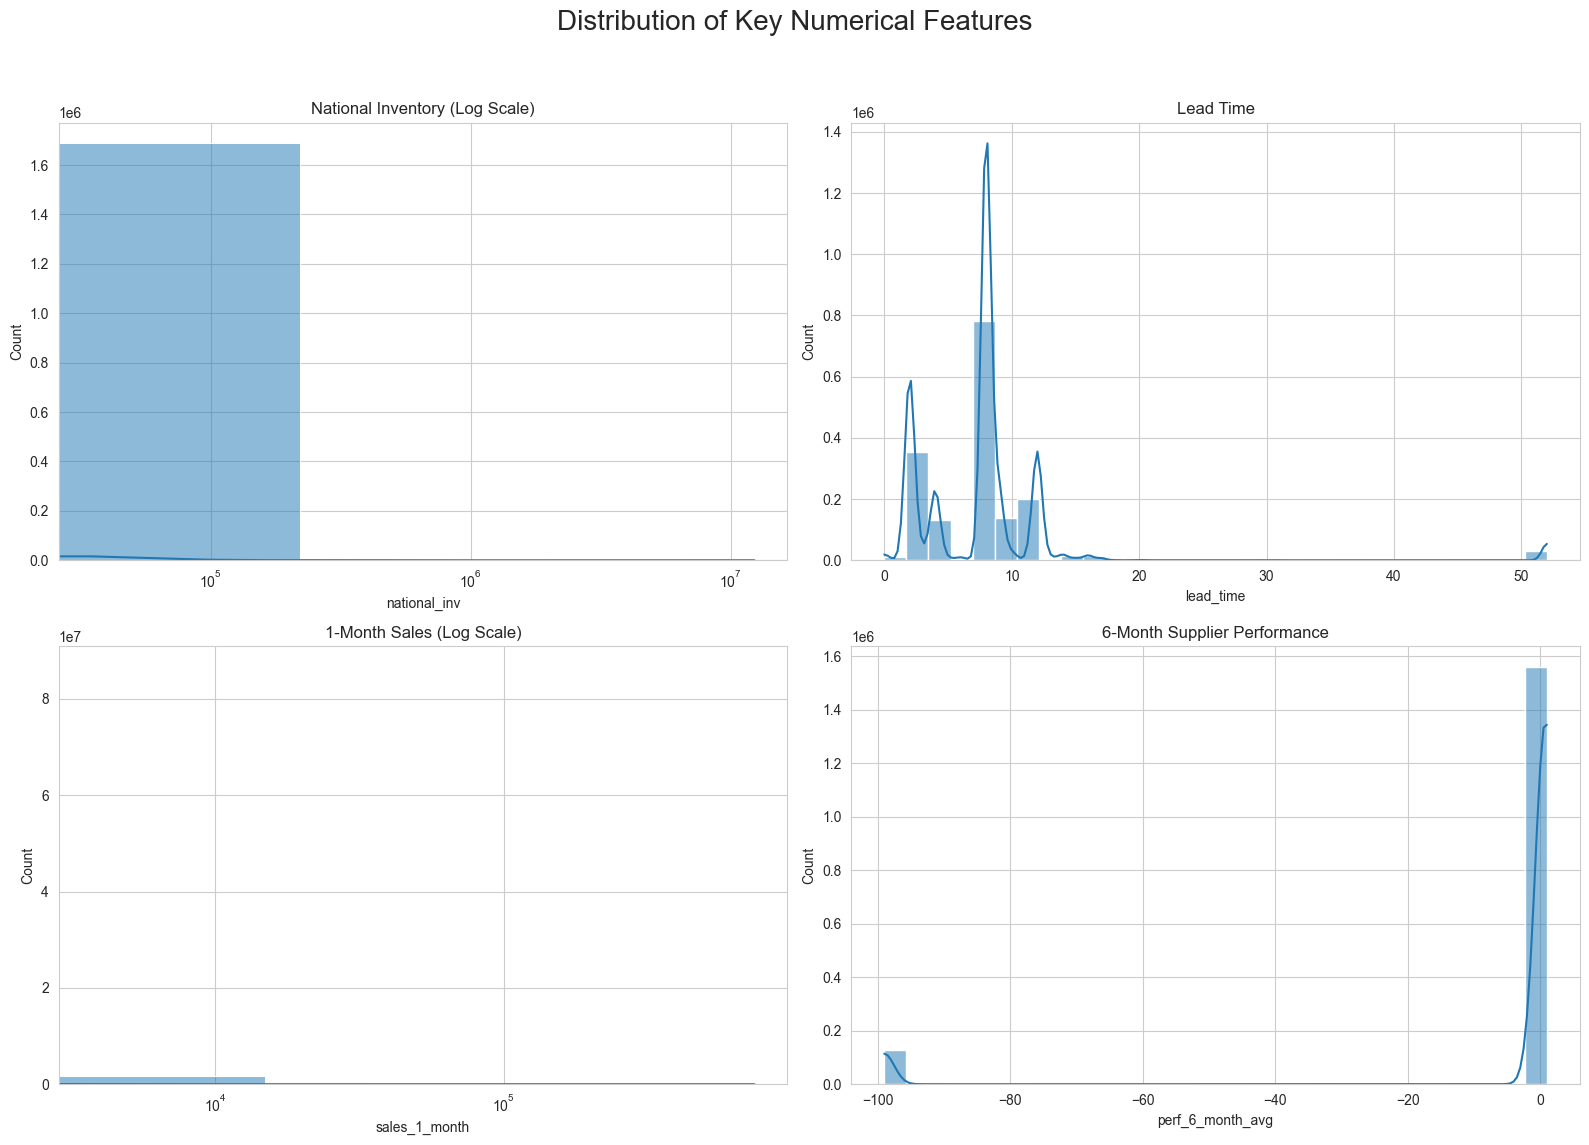

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Key Numerical Features', fontsize=20)

# Plot distributions for a few key features
# Using a log scale for inventory due to extreme skew
sns.histplot(data_train['national_inv'], bins=50, ax=axes[0, 0], kde=True).set_title('National Inventory (Log Scale)')
axes[0, 0].set_xscale('log')

sns.histplot(data_train['lead_time'], bins=30, ax=axes[0, 1], kde=True).set_title('Lead Time')
sns.histplot(data_train['sales_1_month'], bins=50, ax=axes[1, 0], kde=True).set_title('1-Month Sales (Log Scale)')
axes[1, 0].set_xscale('log')

sns.histplot(data_train['perf_6_month_avg'], bins=30, ax=axes[1, 1], kde=True).set_title('6-Month Supplier Performance')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
# Get descriptive statistics for numerical columns
# We'll select a few key features to keep the output readable
numerical_features = ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'sales_1_month', 'min_bank']
data_train[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
national_inv,1687860.0,496.111782,29615.233831,-27256.0,4.0,15.0,80.0,12334404.0
lead_time,1687860.0,7.879902,6.841952,0.0,4.0,8.0,8.0,52.0
in_transit_qty,1687860.0,44.052022,1342.741731,0.0,0.0,0.0,0.0,489408.0
forecast_3_month,1687860.0,178.119284,5026.553102,0.0,0.0,0.0,4.0,1427612.0
sales_1_month,1687860.0,55.926069,1928.195879,0.0,0.0,0.0,4.0,741774.0
min_bank,1687860.0,52.772303,1254.983089,0.0,0.0,0.0,3.0,313319.0


The key numerical features are heavily right-skewed and contain extreme outliers. Features like national_inv and sales_1_month show that a vast majority of products have very low inventory and sales, while a few have exceptionally high values, necessitating the log scale for visualization. The lead_time distribution is multi-modal, with a significant peak around 8, suggesting common, standardized lead times. Furthermore, the perf_6_month_avg plot, with its large spikes at 0 and -99, indicates these may be coded values representing specific statuses (e.g., on-time, no data) rather than a continuous performance metric. These patterns highlight the need for data transformation (like log scaling) and careful handling of outliers and potential data entry errors (such as the negative minimum for national_inv) before modeling.

### 2. Examine Numerical Features

Let's look at the summary statistics for the numerical columns to understand their scale, central tendency, and spread. This can help spot potential outliers or skewed distributions.

Target Variable Distribution:
went_on_backorder
No     1676567
Yes      11293
Name: count, dtype: int64

Percentage of backorders: 0.67%


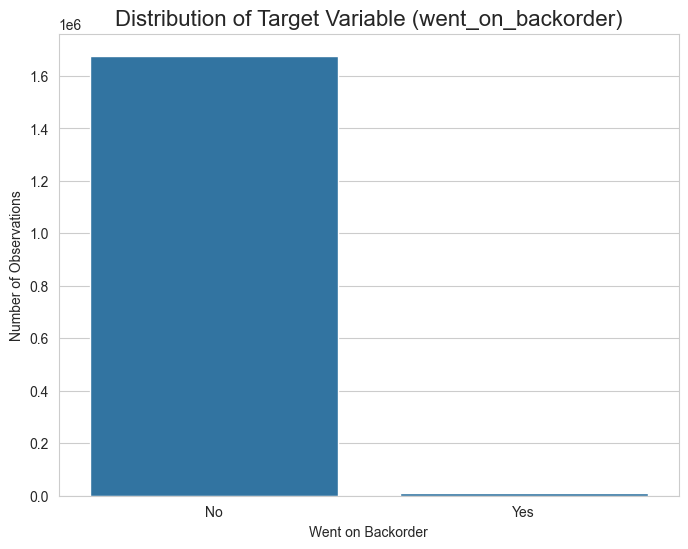

In [13]:
# Calculate and print the class distribution
target_counts = data_train['went_on_backorder'].value_counts()
print("Target Variable Distribution:")
print(target_counts)
print(f"\nPercentage of backorders: {target_counts['Yes'] / len(data_train) * 100:.2f}%")

# Visualize the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='went_on_backorder', data=data_train, order=['No', 'Yes'])
plt.title('Distribution of Target Variable (went_on_backorder)', fontsize=16)
plt.ylabel('Number of Observations')
plt.xlabel('Went on Backorder')
plt.show()

In [16]:
data_train.to_csv('../data/train_clean.csv', index=False)
data_test.to_csv('../data/train_test.csv', index=False)


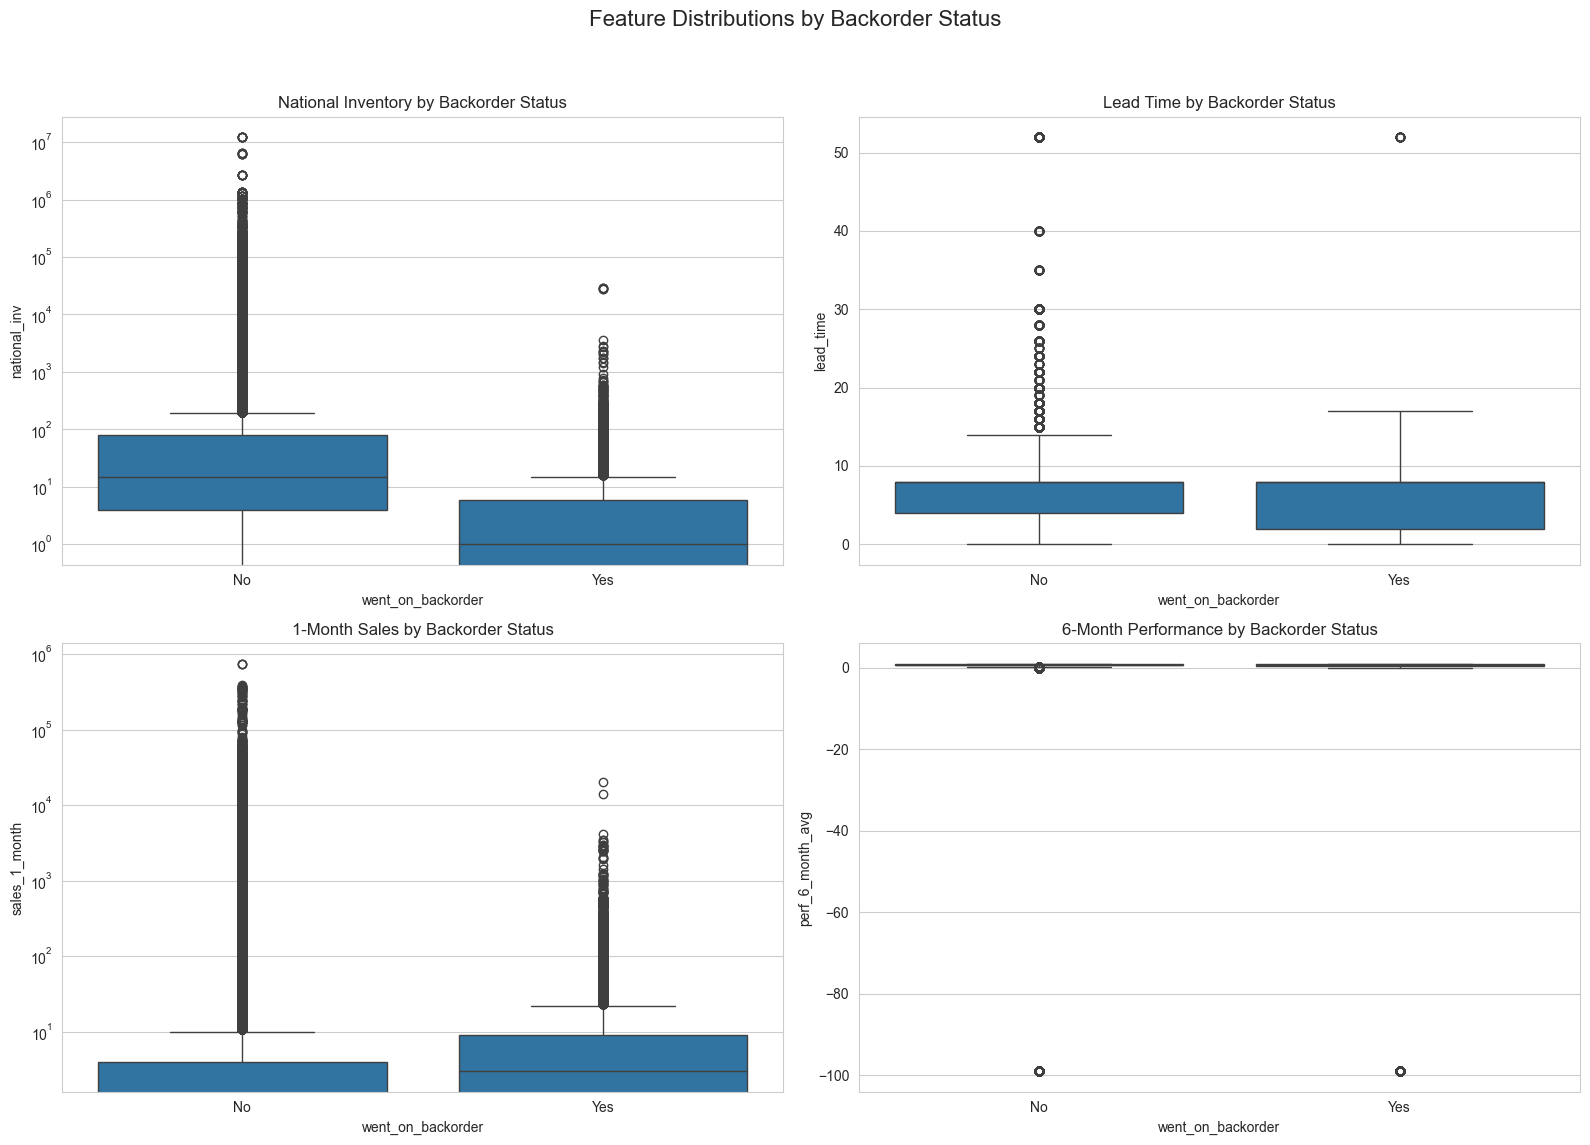

In [14]:
# Create box plots to compare feature distributions between backorder and non-backorder items
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Distributions by Backorder Status', fontsize=16)

# Log scale for inventory
sns.boxplot(x='went_on_backorder', y='national_inv', data=data_train, ax=axes[0, 0])
axes[0, 0].set_yscale('log')
axes[0, 0].set_title('National Inventory by Backorder Status')

# Lead time
sns.boxplot(x='went_on_backorder', y='lead_time', data=data_train, ax=axes[0, 1])
axes[0, 1].set_title('Lead Time by Backorder Status')

# Sales (log scale)
sns.boxplot(x='went_on_backorder', y='sales_1_month', data=data_train, ax=axes[1, 0])
axes[1, 0].set_yscale('log')
axes[1, 0].set_title('1-Month Sales by Backorder Status')

# Performance
sns.boxplot(x='went_on_backorder', y='perf_6_month_avg', data=data_train, ax=axes[1, 1])
axes[1, 1].set_title('6-Month Performance by Backorder Status')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Key Findings and Next Steps

1. **Class Imbalance (0.67% backorders)**
   - Will need to use techniques like SMOTE or class weights in modeling
   - Must use metrics like Precision-Recall AUC instead of accuracy

2. **Data Quality Issues**
   - Negative inventory values need investigation
   - Coded values in performance metrics (-99, 0) need special handling

3. **Feature Transformations Needed** (to be done in feature engineering notebook)
   - Log transformation for highly skewed features
   - Standardization/normalization for different scales
   - One-hot encoding for categorical-like numerical features
   - Potential feature interactions (e.g., inventory-to-sales ratio)

The next step is to move to the feature engineering notebook (02_feature_engineering.ipynb) to implement these transformations.